In [1]:
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import preprocessing
from scipy import stats
import scipy.io as sio
import h5py

Load & Reorder:

In [2]:
# Load
path = "../Data/090085/Road_Data/res_serv_road_livi/patch_set.h5"

data = h5py.File(path, 'r')
X = np.array(data['image_patch'])
Y = np.array(data['road_existence'])
Road_patch = np.array(data['road_patch'])
data.close()

In [3]:
# Construct training & test set
index_mask = np.arange(X.shape[0])
np.random.shuffle(index_mask)

train_index = index_mask[:int(index_mask.size*0.75)]
test_index = index_mask[int(index_mask.size*0.75):]

train_x = X[train_index].flatten().reshape((train_index.size, -1))
train_y = Y[train_index]
train_road_patch = Road_patch[train_index]

test_x = X[test_index].flatten().reshape((test_index.size, -1))
test_y = Y[test_index]
test_road_patch = Road_patch[test_index]

print(train_x.shape, train_y.shape, train_road_patch.shape)
print(test_x.shape, test_y.shape, test_road_patch.shape)

(260498, 5488) (260498,) (260498, 28, 28)
(86833, 5488) (86833,) (86833, 28, 28)


Model parameters: 

In [4]:
width = 28
height = 28
band = 7

L1_out = 512
L2_out = 256
L3_out = 128
L4_out = 64
class_output = 1 # number of possible classifications for the problem

batch_size = 64
learning_rate = 9e-6
iteration = 50000

Calculate Normalization Parameters:

In [5]:
# Normalize Parameters
mu = train_x.mean(axis=0, keepdims=True)
sigma = 0
for img in train_x:
    sigma += (img-mu)**2
sigma /= train_x.shape[0]

$a_i$ is the raw number (int)

$\mu = \frac 1 n \sum_{i=1}^n \frac {a_i} {\text{Max}} = \frac 1 {\text{Max}}(\frac 1 n \sum_{i=1}^n a_i)$

$\sigma = \sqrt{\frac 1 n \sum_{i=1}^n (\frac{a_i}{\text{Max}}-\mu)^2 } = \frac 1 {\text{Max}} \sqrt{\frac 1 n \sum_{i=1}^n(a_i-\mu*\text{Max})^2 } $

$\displaystyle \frac {\frac A {\text{Max}} - mu} {\sigma} = \frac {A-\mu *\text{Max}}{\sigma *\text{Max}}$

Place holders for inputs and outputs: 

In [6]:
x = tf.placeholder(tf.float32, shape=[None, width*height*band])
y = tf.placeholder(tf.float32, shape=[None, class_output])

Fully Connected Layer: 

In [7]:
# Layer 1
W_fc1 = tf.Variable(tf.truncated_normal([width*height*band, L1_out], stddev=0.1))
b_fc1 = tf.Variable(tf.truncated_normal([L1_out], stddev=0.1))

fc1=tf.matmul(x, W_fc1) + b_fc1 # applying weights and biases
h_fc1 = tf.nn.relu(fc1) # ReLU activation

# Layer 2
W_fc2 = tf.Variable(tf.truncated_normal([L1_out, L2_out], stddev=0.1))
b_fc2 = tf.Variable(tf.truncated_normal([L2_out], stddev=0.1))

fc2=tf.matmul(h_fc1, W_fc2) + b_fc2# applying weights and biases
h_fc2 = tf.nn.relu(fc2) # ReLU activation

# Layer 3
W_fc3 = tf.Variable(tf.truncated_normal([L2_out, L3_out], stddev=0.1))
b_fc3 = tf.Variable(tf.truncated_normal([L3_out], stddev=0.1))

fc3=tf.matmul(h_fc2, W_fc3) + b_fc3
h_fc3 = tf.nn.relu(fc3) # ReLU activation

# Layer 4
W_fc4 = tf.Variable(tf.truncated_normal([L3_out, L4_out], stddev=0.1))
b_fc4 = tf.Variable(tf.truncated_normal([L4_out], stddev=0.1))

fc4=tf.matmul(h_fc3, W_fc4) + b_fc4
h_fc4 = tf.nn.relu(fc4) # ReLU activation

Output Layer (Softmax):

In [8]:
W_fc_out = tf.Variable(tf.truncated_normal([L4_out, class_output], stddev=0.1))
b_fc_out = tf.Variable(tf.truncated_normal([class_output], stddev=0.1))

fc_out=tf.matmul(h_fc4, W_fc_out) + b_fc_out

y_CNN= tf.sigmoid(fc_out)
prediction = tf.cast(tf.round(y_CNN), tf.int32)

Cost function & optimizer:

In [9]:
cross_entropy = -tf.reduce_mean(tf.reduce_sum((y * tf.log(y_CNN) + (1-y) * tf.log(1-y_CNN)), axis=1))
cross_entropy_sum = -tf.reduce_sum(y * tf.log(y_CNN)+(1-y) * tf.log(1-y_CNN))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

In [10]:
accuracy = tf.reduce_mean(tf.cast(tf.equal(y, tf.round(y_CNN)), "float"))

Train & monitor:

In [11]:
saver = tf.train.Saver()

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_mask = np.arange(train_x.shape[0]) # shuffle the dataset
np.random.shuffle(train_mask)
batch_num = int(train_mask.size/batch_size)

learning_curve = []
F1_curve = []

for i in range(iteration):
    start = i%batch_num * batch_size
    end = start + batch_size

    if end > train_mask.size:
        end = train_mask.size
        np.random.shuffle(train_mask)
    
    index = train_mask[start:end]    
    batch = [((train_x[index]-mu)/sigma), np.matrix(train_y[index]).astype(int).T]

    # snap shot
    if i%1000 == 0:
        pred = prediction.eval(feed_dict={x:batch[0], y: batch[1]})
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y: batch[1]})
        
        # compute metric
        true_neg = np.logical_and(pred == batch[1], np.logical_not(batch[1])).sum()
        false_neg = (np.logical_not(batch[1]).sum()) - true_neg
        true_pos = (np.logical_and(pred == batch[1], batch[1])).sum()
        false_pos = batch[1].sum() - true_pos

        precision = true_neg / (true_neg + false_neg)
        recall = true_neg / (true_neg + false_pos)
        
        train_F1_score = 2*(recall*precision) / (recall+precision)
        
        learning_curve.append(train_accuracy)
        F1_curve.append(train_F1_score)
        
    train_step.run(feed_dict={x: batch[0], y: batch[1]})
print("finish")

/home/admin-u6142160/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in long_scalars


finish


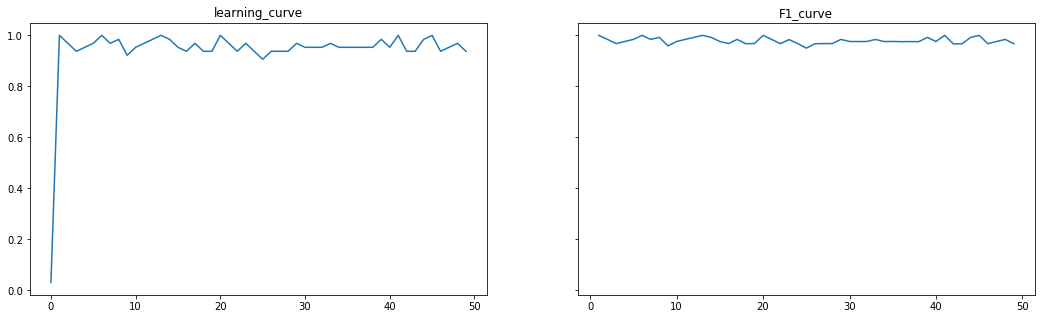

In [12]:
# plot training curve
fig, subfig = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(18,5))
subfig[0].plot(learning_curve)
subfig[0].set_title('learning_curve')
    
subfig[1].plot(F1_curve)
subfig[1].set_title('F1_curve')    
plt.show()

Evaluate:

In [13]:
train_acc = []
train_F1 = []
train_pred_label = np.zeros(train_mask.size)

batch_num = int(train_mask.size/batch_size)+1
for i in range(batch_num):
    start = i%batch_num * batch_size
    end = start + batch_size

    if end > train_mask.size:
        end = train_mask.size
    
    batch = [((train_x[start:end]-mu)/sigma), np.matrix(train_y[start:end]).T]

    train_accuracy = accuracy.eval(feed_dict={x:batch[0], y: batch[1]})
    train_acc.append(train_accuracy * (end-start))
    
    # compute metric   
    pred = prediction.eval(feed_dict={x:batch[0], y: batch[1]})

    train_pred_label[start:end] = pred.T
    
    true_neg = np.logical_and(pred == batch[1], np.logical_not(batch[1])).sum()
    false_neg = (np.logical_not(batch[1]).sum()) - true_neg
    true_pos = (np.logical_and(pred == batch[1], batch[1])).sum()
    false_pos = batch[1].sum() - true_pos
    
    precision = true_neg / (true_neg + false_neg)
    recall = true_neg / (true_neg + false_pos)     

    train_F1.append(2*(recall*precision) / (recall+precision)* (end-start))
            
print("train_acc", sum(train_acc)/train_mask.size, " train_F1 = ", sum(train_F1)/train_mask.size)

train_acc 0.962022741058  train_F1 =  0.980319982211


In [14]:
test_mask = np.arange(test_x.shape[0])
np.random.shuffle(test_mask)
batch_num = int(test_mask.size/batch_size)+1

test_acc = []
test_F1 = []
test_pred_label = np.zeros(test_mask.size)

for i in range(batch_num):
    start = i%batch_num * batch_size
    end = start + batch_size

    if end > test_mask.size:
        end = test_mask.size
    
    batch = [((test_x[start:end]-mu)/sigma), np.matrix(test_y[start:end]).T]

    test_accuracy = accuracy.eval(feed_dict={x:batch[0], y: batch[1]})
    test_acc.append(test_accuracy * (end-start))

    # compute metric   
    pred = prediction.eval(feed_dict={x:batch[0], y: batch[1]})        

    test_pred_label[start:end] = pred.T
    
    true_neg = np.logical_and(pred == batch[1], np.logical_not(batch[1])).sum()
    false_neg = (np.logical_not(batch[1]).sum()) - true_neg
    true_pos = (np.logical_and(pred == batch[1], batch[1])).sum()
    false_pos = batch[1].sum() - true_pos
    
    precision = true_neg / (true_neg + false_neg)
    recall = true_neg / (true_neg + false_pos)     

    test_F1.append(2*(recall*precision) / (recall+precision)* (end-start))
    
print("test_acc = ", sum(test_acc)/test_mask.size, "test_F1 = ", sum(test_F1)/test_mask.size)

test_acc =  0.962583349665 test_F1 =  0.980623670777


(Optional) Save the model

In [15]:
save_path = './Result/models/res_serv_road_livi/'
model_name = 'res_serv_road_livi'
saver.save(sess, save_path + model_name)

h5f = h5py.File(save_path + "training_info.h5", 'w')

h5f_Index = h5f.create_group("Index")
h5f_Index.create_dataset(name='train_index', shape=train_index.shape, data=train_index)
h5f_Index.create_dataset(name='test_index', shape=test_index.shape, data=test_index)

h5f_Norm = h5f.create_group("Norm")
h5f_Norm.create_dataset(name='mu', shape=mu.shape, data=mu)
h5f_Norm.create_dataset(name='sigma', shape=sigma.shape, data=sigma)
h5f.close()

In [19]:
print(int(index_mask.size*0.75), train_index.size, test_index.size)

260498 260498 86833
